# Demos

Demo 1: Object detection

Demo 2: Style transfer

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


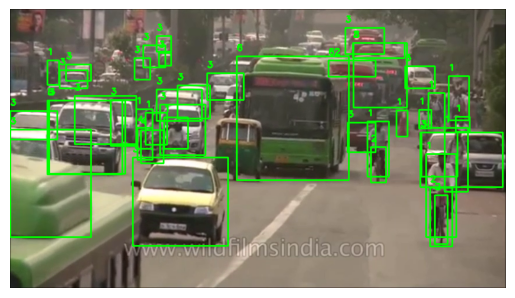

In [ ]:
#Demo 1
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import cv2
import matplotlib.pyplot as plt

# Define thedevice
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the pretrained Faster R-CNN model with ResNet-50 backbone
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

# Load the video file
video_path = 'traffic-mini.mp4'
cap = cv2.VideoCapture(video_path)

# Define the transform to be applied to each frame
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to perform object detection on a single frame
def detect_objects(frame):
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Apply the transform
    input_tensor = transform(frame_rgb).unsqueeze(0).to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)[0]
    
    # Extract bounding boxes, labels, and scores
    boxes = output['boxes'].cpu().numpy().astype(int)
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    
    # Draw bounding boxes and labels on the frame
    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Filter out low-confidence detections
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.putText(frame, f'{label}', (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return frame


fig,ax = plt.subplots(1,1)
ax.axis('off')
hdisplay = display("", display_id=True)

# Loop through the video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform object detection on the current frames
    frame_with_detections = detect_objects(frame)
    
    # Display the frame with detections using Matplotlib
    ax.imshow(cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB))
    hdisplay.update(fig)
    
    
# Release the video capture and close all windows
cap.release()


In [ ]:
# Demo 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import tensorflow as tf

import time

# Helper functions
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]

    return img    

# Function to load an image from a file, and add a batch dimension.
def load_content_img(image_pixels):
    if image_pixels.shape[-1] == 4:
        image_pixels = Image.fromarray(image_pixels)
        img = image_pixels.convert('RGB')
        img = np.array(img)
        img = tf.convert_to_tensor(img)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 3:
        img = tf.convert_to_tensor(image_pixels)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        return img
    elif image_pixels.shape[-1] == 1:
        raise Error('Grayscale images not supported! Please try with RGB or RGBA images.')
    print('Exception not thrown')

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

print("Finding style of picture")
urls = {
    'IMAGE_1': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
    'IMAGE_2': 'https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg',
    'IMAGE_3': 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg',
    'IMAGE_4': 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg/800px-Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
    'IMAGE_5': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
}

STYLE_IMAGE_NAME = 'IMAGE_1'
style_image_path = tf.keras.utils.get_file(STYLE_IMAGE_NAME + ".jpg", urls[STYLE_IMAGE_NAME])
style_image = load_img(style_image_path)
preprocessed_style_image = preprocess_image(style_image, 256)
print("Style image downloaded!")

# code om model in te laden
print('loading model...')
style_predict_path = '/kaggle/input/arbitrary-image-stylization-inceptionv3/tflite/dynamic-shapes-int8-predict/1/1.tflite'
style_transform_path = '/kaggle/input/arbitrary-image-stylization-inceptionv3/tflite/dynamic-shapes-int8-transfer/1/1.tflite'
interpreter = tf.lite.Interpreter(model_path=style_predict_path)
# Stylize image 🥁

content_blending_ratio = 0 #@param {type:"slider", min:0, max:1, step:0.1}
#@markdown You're encouraged to play with the different values of `content_blending_ratio`.

content_image_size = 350 #@param {type:"slider", min:192, max:512, step:1}

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, content_image_size)
preprocessed_style_image = preprocess_image(style_image, 256)

print('Preprocessing the style and the content images...')
print('Style image shape:', preprocessed_style_image.shape)
print('Content image shape:', preprocessed_content_image.shape)

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image, 'Style Image')

# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
print('Calculating style bottleneck...')
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)
print('Stylizing image. It should not take more than three minutes...')

# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  for index in range(len(input_details)):
    if input_details[index]["name"]=='content_image':
      index = input_details[index]["index"]
      interpreter.resize_tensor_input(index, [1, content_image_size, content_image_size, 3])
  interpreter.allocate_tensors()

  # Set model inputs.
  for index in range(len(input_details)):
    if input_details[index]["name"]=='Conv/BiasAdd':
      interpreter.set_tensor(input_details[index]["index"], style_bottleneck)
    elif input_details[index]["name"]=='content_image':
      interpreter.set_tensor(input_details[index]["index"], preprocessed_content_image)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
)

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck_blended, preprocessed_content_image)

# Visualize the output.
plt.subplot(1, 3, 3)
imshow(stylized_image, 'Stylized Image')